<a href="https://colab.research.google.com/github/VU-CSP/github-classroom-intro-handalls/blob/main/doseResponse_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dose–Response Relationships  

You will need to edit the file Quiz.md to get autograded for this assignment.  

The first part of the assignment will have you performing analysis on Vanderbilt's Thunor instance.  

You can access the plots for afatinib treatment using DIP rate or viability at 72 h by following [this link](https://thunor.app.vanderbilt.edu/plots?dataset=13&colsLg=3&colsMd=2&plotdata=plotType%3Ddrc%26datasetId%3D13%26dataset2Id%3D%26useCellLineTags%3Doff%26c%3D8%26c%3D9%26c%3D10%26c%3D11%26c%3D12%26c%3D17%26c%3D18%26useDrugTags%3Doff%26d%3D5%26colorBy%3Doff%26drMetric%3Ddip%26drcType%3Drel&plotdata=plotType%3Ddrc%26datasetId%3D13%26dataset2Id%3D%26useCellLineTags%3Doff%26c%3D8%26c%3D9%26c%3D10%26c%3D11%26c%3D12%26c%3D17%26c%3D18%26useDrugTags%3Doff%26d%3D5%26colorBy%3Doff%26drMetric%3Dviability%26drcType%3Drel)  

Then you can add new plots as needed to answer the questions in the Quiz.md. You must modify the Quiz.md file to get your grade (either modify the file directly on GitHub or upload to your assignment repository.)  


You can learn more about Thunor web and how to use it in [this tutorial](https://youtu.be/q4LQCjuBnmg).  


## Assignment

Task 1)
Got to [thunor.app.vanderbilt.edu](https://thunor.app.vanderbilt.edu/plots?dataset=13&colsLg=3&colsMd=2&plotdata=plotType%3Ddrc%26datasetId%3D13%26dataset2Id%3D%26useCellLineTags%3Doff%26c%3D8%26c%3D9%26c%3D10%26c%3D11%26c%3D12%26c%3D17%26c%3D18%26useDrugTags%3Doff%26d%3D5%26colorBy%3Doff%26drMetric%3Ddip%26drcType%3Drel&plotdata=plotType%3Ddrc%26datasetId%3D13%26dataset2Id%3D%26useCellLineTags%3Doff%26c%3D8%26c%3D9%26c%3D10%26c%3D11%26c%3D12%26c%3D17%26c%3D18%26useDrugTags%3Doff%26d%3D5%26colorBy%3Doff%26drMetric%3Dviability%26drcType%3Drel) and compare the responses of all cell lines to afatinib using DIP rate or 72 h viability as the effect metric.

Task 2) Complete all tasks within this notebook  

Task 3) Edit and submit the Quiz.md file in your assigment repository (you will need to refer to thunor@VU and this notebook).  

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    try:
        import thunor
    except:
        !pip install thunor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
import thunor
from thunor.io import read_hdf
from thunor.dip import dip_rates
from thunor.curve_fit import fit_params
%matplotlib inline

#### Define model functions

In [3]:
def ll4(x,h,E0,Emax,EC50):
    '''
    Reformulation of the LL4 function
     - h: Hill coefficient
     - E0: no-drug effect
     - Emax: max effect
     - EC50: Concentration at midpoint between E0 and Emax
     '''
    return(Emax + (E0-Emax) / (1+np.exp(h*(np.log(x/EC50)))) )

def ll3(x,b,d,e):
    '''
    3-parameter log-logistic function with no/minimal effect set to a value of 1
     - b: Hill coefficient
     - d: Emax
     - e: EC50
     '''
    return(d + (1-d) / ( 1+np.exp( b*np.log(x/e)) ) )

#### Load all PC9 data using Thunor

In [4]:
if IN_COLAB and not os.path.exists("./data/HTS001.h5"):
    if not os.path.exists("./data"):
        !mkdir data
    !wget -O ./data/HTS001.h5 https://github.com/VU-CSP/quantbio-assignments/raw/main/data/HTS001.h5



--2024-03-25 23:54:19--  https://github.com/VU-CSP/quantbio-assignments/raw/main/data/HTS001.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/VU-CSP/quantbio-assignments/main/data/HTS001.h5 [following]
--2024-03-25 23:54:19--  https://raw.githubusercontent.com/VU-CSP/quantbio-assignments/main/data/HTS001.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285259 (1.2M) [application/octet-stream]
Saving to: ‘./data/HTS001.h5’

./data/HTS001.h5    100%[===================>]   1.23M  --.-KB/s    in 0.03s   

2024-03-25 23:54:20 (39.7 MB/s) - ‘./data/HTS001.h5’ saved [1285259/1285259]



#### Description of HTS001.h5 dataset  

* PC9 lung adenocarcinoma cell line and six PC9 variants, each treated with 14 different drugs
* All cell lines were genetically modified to express a nuclear-localized fluorescent protein (H2BmRFP) and assessed by live-cell fluorescence microscopy in multiwell plates
* No cell death indicator was used in these experiments (i.e., some of the cell counts may be of dead cells that retained fluorescent nuclear signal)

In [5]:
hts001 = read_hdf("./data/HTS001.h5")
hts001

HTS Dataset (14 drugs/combos, 7 cell lines)

### Calculate DIP rates and fit parameters for all conditions using Thunor

In [6]:
ctrl_diprates, expt_diprates = dip_rates(hts001)
fit_p = fit_params(ctrl_diprates, expt_diprates)

/usr/local/lib/python3.10/dist-packages/thunor/curve_fit.py:157: RuntimeWarning: invalid value encountered in log
  return c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))
/usr/local/lib/python3.10/dist-packages/thunor/curve_fit.py:224: RuntimeWarning: invalid value encountered in scalar power
  icN = self.ec50 * (ic_frac / (1 - ic_frac - (emax / e0))) ** (


### Examine the fit parameters using `head()`

In [7]:
fit_p.head()

dip_ctrl  \
dataset_id cell_line drug                                                          
13         BR1       afatinib  dose          well_id
1.868750e-12  54148     ...   
           DS3       afatinib  dose          well_id
1.868750e-12  54456     ...   
           DS7       afatinib  dose          well_id
1.868750e-12  54764     ...   
           DS8       afatinib  dose          well_id
1.868750e-12  55072     ...   
           DS9       afatinib  dose          well_id
1.868750e-12  55380     ...   

                                                                        dip_expt  \
dataset_id cell_line drug                                                          
13         BR1       afatinib  dose          well_id
1.868750e-11  53868     ...   
           DS3       afatinib  dose          well_id
1.868750e-11  54176     ...   
           DS7       afatinib  dose          well_id
1.868750e-11  54484     ...   
           DS8       afatinib  dose          well_id
1.868750e-11  54792     ...   
           DS9       afatinib  dose          well_id
1.868750e-11  55100     ...   

                                                                         fit_obj  \
dataset_id cell_line drug                                                          
13         BR1       afatinib  <thunor.curve_fit.HillCurveLL4 object at 0x78d...   
           DS3       afatinib  <thunor.curve_fit.HillCurveLL4 object at 0x78d...   
           DS7       afatinib  <thunor.curve_fit.HillCurveLL4 object at 0x78d...   
           DS8       afatinib  <thunor.curve_fit.HillCurveLL4 object at 0x78d...   
           DS9       afatinib  <thunor.curve_fit.HillCurveLL4 object at 0x78d...   

                               min_dose_measured  max_dose_measured  emax_obs  \
dataset_id cell_line drug                                                       
13         BR1       afatinib       1.868750e-12           0.000004 -0.016577   
           DS3       afatinib       1.868750e-12           0.000004 -0.011857   
           DS7       afatinib       1.868750e-12           0.000004 -0.015582   
           DS8       afatinib       1.868750e-12           0.000004 -0.011272   
           DS9       afatinib       1.868750e-12           0.000004 -0.011257   

                                 aa_obs          label          ic50  \
dataset_id cell_line drug                                              
13         BR1       afatinib  1.512939  BR1\nafatinib  3.006719e-07   
           DS3       afatinib  5.548105  DS3\nafatinib  3.034130e-11   
           DS7       afatinib  4.355910  DS7\nafatinib  5.993042e-11   
           DS8       afatinib  3.708655  DS8\nafatinib  9.443298e-11   
           DS9       afatinib  4.820104  DS9\nafatinib  4.533335e-11   

                                       ec50      emax       einf  emax_rel  \
dataset_id cell_line drug                                                    
13         BR1       afatinib  3.968750e-06 -0.007034 -22.244175 -0.221182   
           DS3       afatinib  3.630411e-11 -0.004809  -0.004809 -0.139991   
           DS7       afatinib  5.188016e-11  0.004615   0.004615  0.118395   
           DS8       afatinib  7.862445e-11  0.006191   0.006191  0.154127   
           DS9       afatinib  4.868199e-11 -0.002011  -0.002011 -0.055564   

                               emax_obs_rel        aa           auc      hill  
dataset_id cell_line drug                                                      
13         BR1       afatinib     -0.521250  1.522150  10006.926303  0.346485  
           DS3       afatinib     -0.345116  5.738045      1.474794  1.375790  
           DS7       afatinib     -0.399753  4.305049      1.272956  1.873320  
           DS8       afatinib     -0.280602  3.978123      1.373802  2.011579  
           DS9       afatinib     -0.311075  5.181684      1.496975  1.478611

### Download DIP rate data (automatically fit to time course data by Thunor)

In [8]:
if not os.path.exists("./data/hts001_diprates.tsv"):
    !wget -O "./data/hts001_diprates.tsv" https://thunor.app.vanderbilt.edu/dataset/13/download/dip_rates

hts001_diprates = pd.read_csv("./data/hts001_diprates.tsv", sep='\t')
hts001_diprates.rename(columns={'cell.line': 'cell_line', 'drug1':'drug', 'drug1.conc':'conc'}, inplace=True)
hts001_diprates.head()


--2024-03-25 23:57:02--  https://thunor.app.vanderbilt.edu/dataset/13/download/dip_rates
Resolving thunor.app.vanderbilt.edu (thunor.app.vanderbilt.edu)... 52.200.144.81, 52.202.96.219, 3.224.136.119, ...
Connecting to thunor.app.vanderbilt.edu (thunor.app.vanderbilt.edu)|52.200.144.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173629 (170K) [text/tab-separated-values]
Saving to: ‘./data/hts001_diprates.tsv’

./data/hts001_dipra 100%[===================>] 169.56K  --.-KB/s    in 0.1s    

2024-03-25 23:57:03 (1.34 MB/s) - ‘./data/hts001_diprates.tsv’ saved [173629/173629]



,plate,well,cell_line,drug,conc,dip_rate,dip_fit_std_err
0,HTS001_BR1-2,B2,BR1,NaN,NaN,0.033001,0.001192
1,HTS001_BR1-2,B3,BR1,erlotinib,3.968750e-06,0.024479,0.000853
2,HTS001_BR1-2,B4,BR1,erlotinib,9.921250e-07,0.028890,0.001007
3,HTS001_BR1-2,B5,BR1,erlotinib,2.480000e-07,0.029436,0.001091
4,HTS001_BR1-2,B6,BR1,erlotinib,6.201250e-08,0.024072,0.000832


### Extract only cell count data from afatinib treatment
Start from full dataset (`hts001`)

In [9]:
afat = hts001.filter(drugs=['afatinib'])
afat

HTS Dataset (1 drugs/combos, 7 cell lines)

### Load thunor plotting functions

In [10]:
from thunor.plots import plot_drc, plot_drc_params, plot_time_course, plot_ctrl_dip_by_plate, plot_plate_map


### Filter fit parameters for all cell lines treated with afatinib, and plot dose–response curves

In [11]:
fit_p_afat = fit_p[fit_p.index.isin(['afatinib'], level='drug')]
fig = plot_drc(fit_p_afat)
fig.update_layout(
    autosize=False,
    width=400,
    height=400,)

### Filter fit parameters by cell line (`BR1`) and drug (`paclitaxel`)
and display result

In [12]:
fp_br1_pacl = fit_p[fit_p.index.isin(['BR1'], level='cell_line') & \
               fit_p.index.isin(['paclitaxel'], level='drug')]
fp_br1_pacl

,,,dip_ctrl,dip_expt,fit_obj,min_dose_measured,max_dose_measured,emax_obs,aa_obs,label,ic50,ec50,emax,einf,emax_rel,emax_obs_rel,aa,auc,hill
dataset_id,cell_line,drug,,,,,,,,,,,,,,,,,
13,BR1,paclitaxel,dose well_id 1.868750e-12 54148 ...,dose well_id 1.868750e-11 54028 ...,None,1.868750e-12,0.000004,-0.025586,4.509109,BR1\npaclitaxel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Show the result of Thunor-fit DIP rates
Saved in `expt_diprates`

In [13]:
expt_diprates

well_num  \
dataset drug          cell_line dose           well_id             
13      (afatinib,)   BR1       (1.86875e-11,) 53868          93   
                                               53869         261   
                                (7.47625e-11,) 53870          92   
                                               53871         260   
                                (3.0525e-10,)  53872          91   
...                                                          ...   
        (trametinib,) PC9       (2.48e-08,)    55991         278   
                                (9.92125e-08,) 55992         109   
                                               55993         277   
                                (3.96875e-07,) 55994         108   
                                               55995         276   

                                                               plate  \
dataset drug          cell_line dose           well_id                 
13      (afatinib,)   BR1       (1.86875e-11,) 53868    HTS001_BR1-2   
                                               53869    HTS001_BR1-2   
                                (7.47625e-11,) 53870    HTS001_BR1-2   
                                               53871    HTS001_BR1-2   
                                (3.0525e-10,)  53872    HTS001_BR1-2   
...                                                              ...   
        (trametinib,) PC9       (2.48e-08,)    55991    HTS001_PC9-2   
                                (9.92125e-08,) 55992    HTS001_PC9-2   
                                               55993    HTS001_PC9-2   
                                (3.96875e-07,) 55994    HTS001_PC9-2   
                                               55995    HTS001_PC9-2   

                                                        dip_rate  \
dataset drug          cell_line dose           well_id             
13      (afatinib,)   BR1       (1.86875e-11,) 53868    0.029535   
                                               53869    0.028068   
                                (7.47625e-11,) 53870    0.028230   
                                               53871    0.029678   
                                (3.0525e-10,)  53872    0.029814   
...                                                          ...   
        (trametinib,) PC9       (2.48e-08,)    55991    0.031916   
                                (9.92125e-08,) 55992    0.012482   
                                               55993    0.010134   
                                (3.96875e-07,) 55994    0.013977   
                                               55995    0.012052   

                                                        dip_fit_std_err  \
dataset drug          cell_line dose           well_id                    
13      (afatinib,)   BR1       (1.86875e-11,) 53868           0.000915   
                                               53869           0.000787   
                                (7.47625e-11,) 53870           0.000882   
                                               53871           0.000935   
                                (3.0525e-10,)  53872           0.001067   
...                                                                 ...   
        (trametinib,) PC9       (2.48e-08,)    55991           0.000954   
                                (9.92125e-08,) 55992           0.001204   
                                               55993           0.001333   
                                (3.96875e-07,) 55994           0.002074   
                                               55995           0.001336   

                                                        dip_first_timepoint  \
dataset drug          cell_line dose           well_id                        
13      (afatinib,)   BR1       (1.86875e-11,) 53868                   31.1   
                                               53869                   48.5   
                                (7.47625e-11,) 53870     

### Filter DIP rates by cell line (`BR1`) and drug (`paclitaxel`)

In [14]:
expt_diprates[expt_diprates.index.isin(['BR1'], level='cell_line')]

well_num  \
dataset drug          cell_line dose           well_id             
13      (afatinib,)   BR1       (1.86875e-11,) 53868          93   
                                               53869         261   
                                (7.47625e-11,) 53870          92   
                                               53871         260   
                                (3.0525e-10,)  53872          91   
...                                                          ...   
        (trametinib,) BR1       (2.48e-08,)    54143         278   
                                (9.92125e-08,) 54144         109   
                                               54145         277   
                                (3.96875e-07,) 54146         108   
                                               54147         276   

                                                               plate  \
dataset drug          cell_line dose           well_id                 
13      (afatinib,)   BR1       (1.86875e-11,) 53868    HTS001_BR1-2   
                                               53869    HTS001_BR1-2   
                                (7.47625e-11,) 53870    HTS001_BR1-2   
                                               53871    HTS001_BR1-2   
                                (3.0525e-10,)  53872    HTS001_BR1-2   
...                                                              ...   
        (trametinib,) BR1       (2.48e-08,)    54143    HTS001_BR1-2   
                                (9.92125e-08,) 54144    HTS001_BR1-2   
                                               54145    HTS001_BR1-2   
                                (3.96875e-07,) 54146    HTS001_BR1-2   
                                               54147    HTS001_BR1-2   

                                                        dip_rate  \
dataset drug          cell_line dose           well_id             
13      (afatinib,)   BR1       (1.86875e-11,) 53868    0.029535   
                                               53869    0.028068   
                                (7.47625e-11,) 53870    0.028230   
                                               53871    0.029678   
                                (3.0525e-10,)  53872    0.029814   
...                                                          ...   
        (trametinib,) BR1       (2.48e-08,)    54143    0.022501   
                                (9.92125e-08,) 54144    0.011880   
                                               54145    0.016449   
                                (3.96875e-07,) 54146    0.006953   
                                               54147    0.010494   

                                                        dip_fit_std_err  \
dataset drug          cell_line dose           well_id                    
13      (afatinib,)   BR1       (1.86875e-11,) 53868           0.000915   
                                               53869           0.000787   
                                (7.47625e-11,) 53870           0.000882   
                                               53871           0.000935   
                                (3.0525e-10,)  53872           0.001067   
...                                                                 ...   
        (trametinib,) BR1       (2.48e-08,)    54143           0.000752   
                                (9.92125e-08,) 54144           0.001022   
                                               54145           0.001056   
                                (3.96875e-07,) 54146           0.001200   
                                               54147           0.001388   

                                                        dip_first_timepoint  \
dataset drug          cell_line dose           well_id                        
13      (afatinib,)   BR1       (1.86875e-11,) 53868                   31.1   
                                               53869                   48.5   
                                (7.47625e-11,) 53870     

In [15]:
br1_afat = afat.filter(cell_lines=['BR1'])

### Plot the time course data of afatinib on BR1 cells
Use `log_yaxis=True` to plot population doublings.

In [16]:
fig = plot_time_course(br1_afat, log_yaxis=True)
fig.update_layout(
    autosize=False,
    width=400,
    height=400,)

### Writing and reading cell count data using Vanderbilt's HTS format
To faciltate executing Python code, we will replace the `.` in column names with `_`.

In [17]:
from pandas.io.parsers.readers import read_csv
if not os.path.exists("./data/afatinib.csv"):
    thunor.io.write_vanderbilt_hts(afat, filename="./data/afatinib.csv")
a = read_csv("./data/afatinib.csv")
a.rename(columns={'cell.line': 'cell_line', 'cell.count': 'cell_count', 'drug1.conc': 'drug1_conc', 'drug1.units': 'drug1_units'}, inplace=True)
a.head()


,drug1,cell_line,drug1_conc,well,upid,time,cell_count,drug1_units
0,afatinib,BR1,1.868750e-11,D22,HTS001_BR1-2,5.7,49.0,M
1,afatinib,BR1,1.868750e-11,D22,HTS001_BR1-2,9.0,59.0,M
2,afatinib,BR1,1.868750e-11,D22,HTS001_BR1-2,21.1,93.0,M
3,afatinib,BR1,1.868750e-11,D22,HTS001_BR1-2,24.4,100.0,M
4,afatinib,BR1,1.868750e-11,D22,HTS001_BR1-2,27.8,115.0,M


### Assemble basic DataFrame of DIP rates of control and paclitaxel-treated BR1 cells


In [18]:
diprates_br1_pacl = hts001_diprates[np.isin(hts001_diprates['drug'], ['paclitaxel']) ]
diprates_br1_pacl = diprates_br1_pacl[diprates_br1_pacl['cell_line'] == 'BR1']
# add control diprates
br1_diprates_ctrl = hts001_diprates[np.logical_and(hts001_diprates['conc'].isna(), hts001_diprates['cell_line']=='BR1')]
diprates_br1_pacl = diprates_br1_pacl.append(br1_diprates_ctrl)


<ipython-input-18-298717f31f1e>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Add log10([drug]) values to facilitate manual plotting

In [19]:
l10_conc = np.log10(diprates_br1_pacl['conc'][diprates_br1_pacl['conc'].notna()])
min_conc = min(l10_conc)-1
n_ctrl_wells = len( diprates_br1_pacl['conc'][diprates_br1_pacl['conc'].isna()])
l10_conc = np.append(l10_conc,np.repeat(min_conc,n_ctrl_wells))
diprates_br1_pacl['l10_conc'] = l10_conc
diprates_br1_pacl.head()

,plate,well,cell_line,drug,conc,dip_rate,dip_fit_std_err,l10_conc
121,HTS001_BR1-2,G13,BR1,paclitaxel,3.968750e-06,-0.006813,0.000790,-5.401346
122,HTS001_BR1-2,G14,BR1,paclitaxel,9.921250e-07,-0.005648,0.001530,-6.003434
123,HTS001_BR1-2,G15,BR1,paclitaxel,2.480000e-07,-0.025586,0.002220,-6.605548
124,HTS001_BR1-2,G16,BR1,paclitaxel,6.201250e-08,0.029093,0.000726,-7.207521
125,HTS001_BR1-2,G17,BR1,paclitaxel,1.550000e-08,-0.007844,0.001042,-7.809668


### Calculate response ratio of DIP rates
Divide all DIP rate values by the mean of the control values

In [20]:
diprates_br1_pacl["resp_ratio"] = diprates_br1_pacl["dip_rate"] / diprates_br1_pacl[diprates_br1_pacl["conc"].isnull()]["dip_rate"].mean()

### Show the structure of the DataFrame

In [21]:
diprates_br1_pacl

,plate,well,cell_line,drug,conc,dip_rate,dip_fit_std_err,l10_conc,resp_ratio
121,HTS001_BR1-2,G13,BR1,paclitaxel,3.968750e-06,-0.006813,0.000790,-5.401346,-0.208729
122,HTS001_BR1-2,G14,BR1,paclitaxel,9.921250e-07,-0.005648,0.001530,-6.003434,-0.173044
123,HTS001_BR1-2,G15,BR1,paclitaxel,2.480000e-07,-0.025586,0.002220,-6.605548,-0.783940
124,HTS001_BR1-2,G16,BR1,paclitaxel,6.201250e-08,0.029093,0.000726,-7.207521,0.891395
125,HTS001_BR1-2,G17,BR1,paclitaxel,1.550000e-08,-0.007844,0.001042,-7.809668,-0.240335
126,HTS001_BR1-2,G18,BR1,paclitaxel,3.720000e-09,-0.005186,0.000742,-8.429457,-0.158888
127,HTS001_BR1-2,G19,BR1,paclitaxel,1.246000e-09,0.015638,0.000616,-8.904482,0.479145
128,HTS001_BR1-2,G20,BR1,paclitaxel,3.052500e-10,0.004428,0.001103,-9.515344,0.135681
129,HTS001_BR1-2,G21,BR1,paclitaxel,7.476250e-11,0.026220,0.000946,-10.126316,0.803353
130,HTS001_BR1-2,G22,BR1,paclitaxel,1.868750e-11,0.027360,0.000709,-10.728449,0.838293


### Plot the DIP rate values of BR1 cells treated with paclitaxel using Seaborn

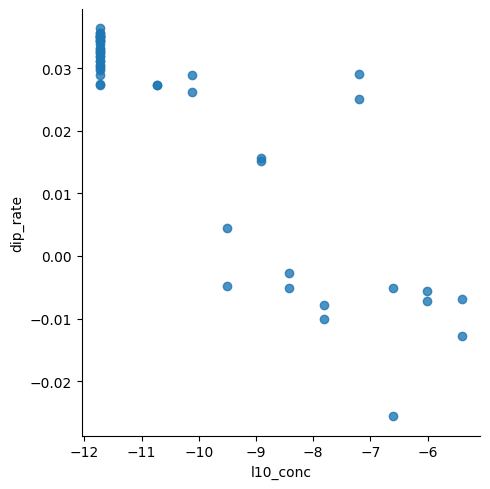

In [22]:
sns.lmplot(x='l10_conc', y='dip_rate', data=diprates_br1_pacl, fit_reg=False)

#### Perform nonlinear regression on data using the `ll4` model  
Let's first look at each of the dates independently to assess consistency.  
#### Use `scipy.optimize.curve_fit` to perform nonlinear regression (fit model parameters)  


In [23]:
fitCoefs, covMatrix = opt.curve_fit(ll4,
                                    10**(diprates_br1_pacl['l10_conc']),
                                    diprates_br1_pacl['dip_rate'],
                                    p0=[1,
                                        np.max(diprates_br1_pacl['dip_rate']),
                                        np.min(diprates_br1_pacl['dip_rate']),
                                        1e-9])
fitCoefs

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



array([ 2.69527518e-01,  4.99380965e-02, -9.96981366e-03,  5.57458520e-11])

# TASK

What is the value that represents the $EC_{50}$ of paclitaxel's effects on BR1 cells? Copy it and save as the answer to Quiz question #6.

In [24]:
fitCoefs[3]

5.574585200140847e-11

### NOTE: Values from paclitaxel of ~6.2e-8 M were found to be artifactual
Drug concentration at this value is inaccurate. Data can be removed to allow more accurate fitting of dose-response model

In [25]:
# remove artifact points
diprates_br1_pacl_drop62 = diprates_br1_pacl[np.logical_or(diprates_br1_pacl['conc'] < 2e-8, diprates_br1_pacl['conc'] > 7e-8)]

# TASK
### Fit the cleaned data with the `ll4` model
NOTE: to get the model to fit you may need some starting parameters (`p0`)

In [26]:
fitCoefs_dropped, covMatrix_dropped = opt.curve_fit(ll4,
                                    10**(diprates_br1_pacl_drop62['l10_conc']),
                                    diprates_br1_pacl_drop62['dip_rate'],
                                    p0=[1,
                                        np.max(diprates_br1_pacl_drop62['dip_rate']),
                                        np.min(diprates_br1_pacl_drop62['dip_rate']),
                                        1e-9])
fitCoefs_dropped  # show the values of the fit parameters; leave this line in

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



array([ 5.24235174e-01,  3.96443004e-02, -1.12955545e-02,  2.23335887e-10])

# TASK

Copy the value that represents the corrected $EC_{50}$ of paclitaxel's effects on BR1 cells and save as the answer to Quiz question #7.

In [30]:
fitCoefs_dropped[3]

2.2333588659887483e-10

#### Plot the data and predicted model fits using Seaborn
NOTE: You will see two curves if you properly fit the cleaned data with the `ll4` model and saved the fit parameters in `fitCoefs_dropped`  

<Axes: xlabel='l10_conc', ylabel='dip_rate'>

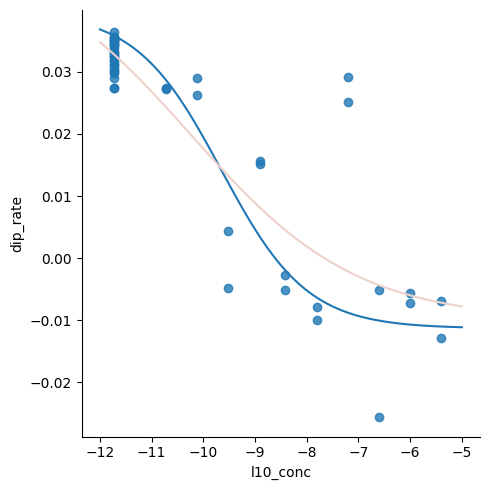

In [31]:
myconc = np.linspace(-12,-5,100)
sns.lmplot(x='l10_conc', y='dip_rate', data=diprates_br1_pacl, fit_reg=False)
if type(fitCoefs_dropped)!=int:
    sns.lineplot(x=myconc, y=[ll4(x, *fitCoefs_dropped) for x in 10**myconc], legend=False)
sns.lineplot(x=myconc, y=[ll4(x, *fitCoefs) for x in 10**myconc], legend=False, hue=2)

#### Perform nonlinear regression on data using `ll3` model  
Use `resp_ratio` values.


In [32]:
fitCoefs_ratio, covMatrix_ratio = opt.curve_fit(ll3, 10**(diprates_br1_pacl_drop62['l10_conc']),
                                    diprates_br1_pacl_drop62['resp_ratio'])
fitCoefs_ratio

array([ 6.15594008e-01, -3.36526687e-01,  4.17293781e-10])

# Task
What is the $E_{max}$ value from the `ll3` model parameters fit to response ratios of BR1 + paclitaxel? Copy it and save the answer to Quiz question #8.

#### Plot the data and predicted model fits using Seaborn

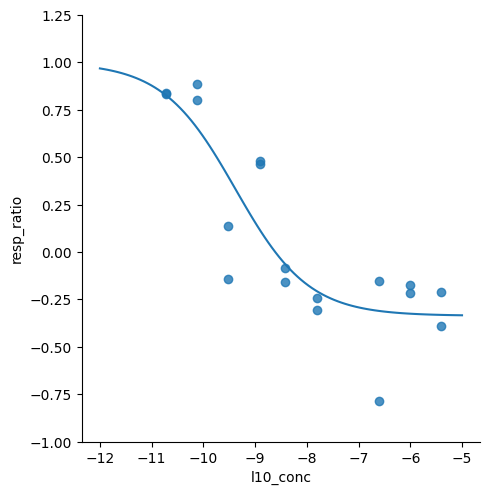

In [33]:
a = sns.lmplot(x='l10_conc', y='resp_ratio', data=diprates_br1_pacl_drop62, fit_reg=False)
a.set(ylim=(-1, 1.25))
l = sns.lineplot(x=[i for i in myconc], y=[ll3(10**i,*fitCoefs_ratio) for i in myconc], legend=False)

In [34]:
print(f"The EC50 of paclitaxel on BR1 cells is {np.round(fitCoefs_ratio[2]*1e9,3)} nM")

The EC50 of paclitaxel on BR1 cells is 0.417 nM


In [35]:
fitCoefs_ratio[1]

-0.3365266866640969